# EECE5644 Summer 2 2022 - HW4

Going over "solutions" for Assignment 4.

## Imports

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
from matplotlib.ticker import MaxNLocator

from math import ceil, floor 

import numpy as np

from scipy.stats import multivariate_normal as mvn

from skimage.io import imread

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [2]:
def plot_binary_classification_results(predictions, labels, title):
    # Get indices of the four decision scenarios:
    # True Negatives
    tn = np.argwhere((predictions == -1) & (y_test == -1))
    # False Positives
    fp = np.argwhere((predictions == 1) & (y_test == -1))
    # False Negative Probability
    fn = np.argwhere((predictions == -1) & (y_test == 1))
    # True Positive Probability
    tp = np.argwhere((predictions == 1) & (y_test == 1))

    # Display correct vs incorrect decisions of classifier
    fig = plt.figure(figsize=(10, 10));

    # class 0 circle, class 1 +, correct green, incorrect red
    plt.plot(X_test[tn, 0], X_test[tn, 1], 'og', label="Correct Class -1");
    plt.plot(X_test[fp, 0], X_test[fp, 1], 'or', label="Incorrect Class -1");
    plt.plot(X_test[fn, 0], X_test[fn, 1], '+r', label="Incorrect Class 1");
    plt.plot(X_test[tp, 0], X_test[tp, 1], '+g', label="Correct Class 1");

    plt.xlabel(r"$x_1$");
    plt.ylabel(r"$x_2$");
    plt.title(title)
    plt.legend();
    plt.tight_layout();
    plt.show()

## Question 1

Train and test Support Vector Machine (SVM) and Multi-layer Perceptron (MLP) classifiers that aim for minimum probability of classification error, i.e., we are using 0-1 loss; all error instances are equally bad. You may use a trusted implementation in your choice of programming language and software packages, e.g., Python coupled with the PyTorch library for MLPs or scikit-learn for SVMs. The SVM should use a Gaussian (sometimes called radial-basis) kernel. The MLP should be a single-hidden layer model with your choice of activation function for all perceptrons.

### Data Generation

Generate 1000 independent and identically distributed (iid) samples for training and 10000 iid samples for testing. All data for class $l \in \{-1,+1\}$ should be generated as follows: 
\begin{equation}
    \mathbf{x}=r_l \begin{bmatrix} \cos(\theta) \\ \sin(\theta) \end{bmatrix} + \mathbf{n}
\end{equation}
where $\theta \sim \text{Uniform}[-\pi,\pi]$ and $\mathbf{n} \sim \mathcal{N}(\mathbf{0},\sigma^2 \mathbf{I})$. Use $r_{-1}=2, r_{+1}=4, \sigma=1$.

<i>Note: The two class sample sets will be two highly overlapping concentric disks, and due to angular symmetry, we anticipate the best classification boundary to be a circle between the two disks. Your SVM and MLP models will try to approximate it. Since the optimal boundary is expected to be a quadratic curve, quadratic polynomial activation functions in the hidden layer of the MLP may be considered as an appropriate modeling choice. If you have time (optional; no bonus marks), experiment with different activation functions to see the effect of this choice.</i>

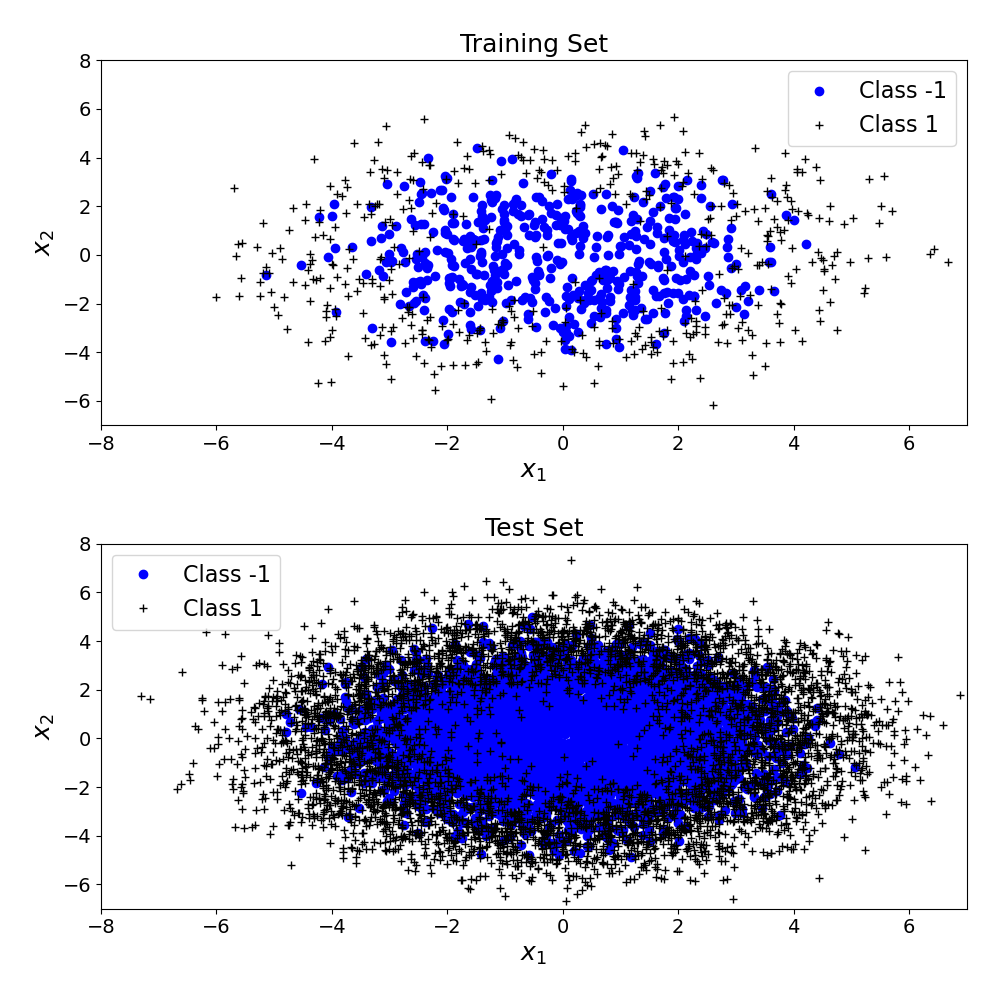

In [3]:
def generate_multiring_dataset(N, n, pdf_params):
    # Output samples and labels
    X = np.zeros([N, n])
    # Note that the labels are either -1 or +1, binary classification
    labels = np.ones(N)
    
    # Decide randomly which samples will come from each class
    indices = np.random.rand(N) < pdf_params['prior']
    # Reassign random samples to the negative class values (to -1)
    labels[indices] = -1
    num_neg = sum(indices)

    # Create mixture distribution
    theta = np.random.uniform(low=-np.pi, high=np.pi, size=N)
    uniform_component = np.array([np.cos(theta), np.sin(theta)]).T

    # Positive class samples
    X[~indices] = pdf_params['r+'] * uniform_component[~indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'],
                                                                           N-num_neg)
    # Negative class samples
    X[indices] = pdf_params['r-'] * uniform_component[indices] + mvn.rvs(pdf_params['mu'], pdf_params['Sigma'],
                                                                         num_neg)
    return X, labels

# Two-dimensional data
n = 2
# Mixture distribution of a uniform and Gaussian RV for a two-class problem
mix_pdf = {}
mix_pdf['r+'] = 4
mix_pdf['r-'] = 2
mix_pdf['prior'] = 0.5
mix_pdf['mu'] = np.zeros(n)
mix_pdf['Sigma'] = np.identity(n)

# Number of training and test set samples
N_train = 1000
N_test = 10000

# Generate training and test sets
X_train, y_train = generate_multiring_dataset(N_train, n, mix_pdf)
X_test, y_test = generate_multiring_dataset(N_test, n, mix_pdf)

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].set_title("Training Set")
ax[0].plot(X_train[y_train==-1, 0], X_train[y_train==-1, 1], 'bo', label="Class -1")
ax[0].plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'k+', label="Class 1")
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[0].legend()

ax[1].set_title("Test Set")
ax[1].plot(X_test[y_test==-1, 0], X_test[y_test==-1, 1], 'bo', label="Class -1")
ax[1].plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'k+', label="Class 1")
ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$x_2$")
ax[1].legend()

# Using test set samples to limit axes
x1_lim = (floor(np.min(X_test[:,0])), ceil(np.max(X_test[:,0])))
x2_lim = (floor(np.min(X_test[:,1])), ceil(np.max(X_test[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_lim, ylim=x2_lim)
plt.tight_layout()
plt.show()

### Model Order Selection

Use 10-fold cross-validation on the training data to determine the best hyperparameters. For SVMs, these will be the box constraints or regularization parameter on the max-margin objective to prevent overfitting, $\lambda$ as in lecture notes or sometimes denoted as $C$, as well as the Gaussian kernel bandwidth, $\gamma = \frac{1}{2\sigma^2}$. For the MLP, this will be the number of perceptrons in the hidden layer. Once these hyperparameters are set, train your final SVM and MLP classifier using the entire training data set. Apply your trained SVM and MLP classifiers to the test data set and estimate the probability of error from this data set. 

<i>Note: When performing hyperparameter selection on combinations of hyperparameters, as in the SVM where you wish to select the best $C$ <b>and</b> $\gamma$, then it is common to perform a grid-search over all possible combinations of hyperparameters. Whilst this is computationally expensive, as you are exploring all possible combinations of the hyperparameters, it ensures that you have the best model setting. Please look at the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class and the [user guide](https://scikit-learn.org/stable/modules/grid_search.html\#grid-search) for more information.<i>

### SVM

> Let's begin with the SVM classifier, which is obtained via the optimization problem:

> $$\min_\mathbf{w} ||\mathbf{w}||^2 + \lambda \sum_{i=1}^N (1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)})_+.$$

> <b>Aside:</b> Refer to the [SVM example](../svms/svm.ipynb) for more information, but note that the above is known as the <b>primal problem</b>, which has a non-differentiable objective due to the Hinge loss term. You might see the SVM classifier solved instead using the <b>dual form</b> of this objective, to which you have a differentiable maximization problem. Refer to Murphy's chapter 17.3.2 or [here](https://en.wikipedia.org/wiki/Support-vector_machine#Computing_the_SVM_classifier) for more information. Alternatively, you can also use a [subgradient method](https://en.wikipedia.org/wiki/Subgradient_method) as a get around to work directly with the primal problem, but this will not enable us to make use of the invaluable "Kernel trick".

> In the dual form of an SVM, there are inner products $\langle \mathbf{x}^{(i)}, \mathbf{x}^{(j)}\rangle$, which can be replaced by <b>kernel functions</b> $K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})$. The benefit of this replacement is that we can learn a nonlinear classification rule in a transformed feature space $\phi$ without explicitly computing the feature representations for each $\phi(\mathbf{x}^{(i)})$. 

> For our task, we will consider specifically the RBF or Gaussian kernel:

> $$ K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = \exp \left(-\frac{||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2}{2\sigma^2}\right), $$

> choosing an optimal $\gamma = \frac{1}{2\sigma^2}$ and regularization parameter ($\lambda$ or $C$) during the hyperparameter selection procedure. See below the implementation for this model selection using a [grid-search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) on the SVM classifier.

Best Regularization Strength: 100.000
Best Kernel Width: 0.001
SVM CV Pr(error): 0.171


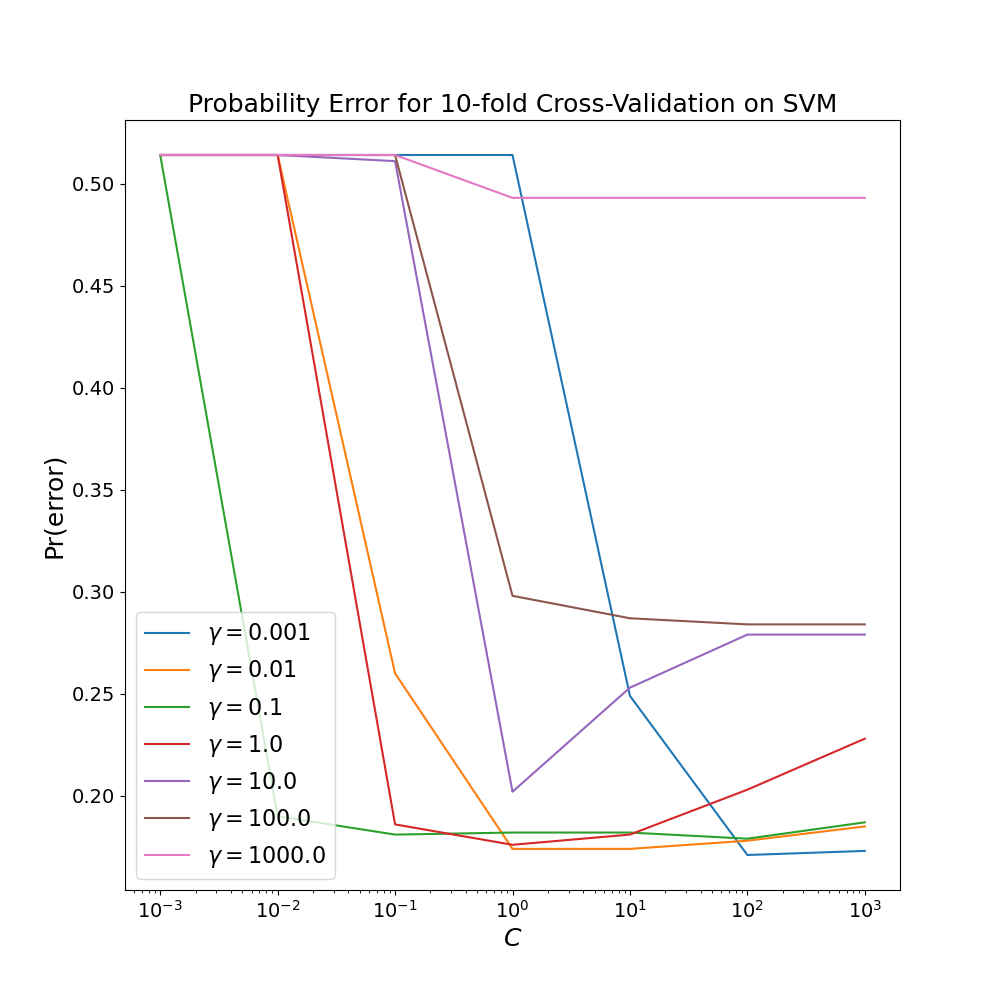

In [4]:
# 10-fold CV
K = 10

# Set up parameters to evaluate using GridSearchCV
C_range = np.logspace(-3, 3, 7)
#C_range = np.array((0.1, 1))
gamma_range = np.logspace(-3, 3, 7)
#gamma_range = np.array((0.1, 1))
param_grid = {'C': C_range, 'gamma': gamma_range}

# Specifying that we'll use the Gaussian kernel
svc = SVC(kernel='rbf')
cv = KFold(n_splits=K, shuffle=True)
classifier = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv)
classifier.fit(X_train, y_train)

C_best = classifier.best_params_['C']
gamma_best = classifier.best_params_['gamma']
print("Best Regularization Strength: %.3f" % C_best)
print("Best Kernel Width: %.3f" % gamma_best)
print("SVM CV Pr(error): %.3f" % (1-classifier.best_score_))

# Plot Pr(error) vs regularization parameter when gamma is held constant
C_data = classifier.cv_results_['param_C'].data
gamma_data = classifier.cv_results_['param_gamma'].data
cv_prob_error = 1 - classifier.cv_results_['mean_test_score']
plt.figure(figsize=(10, 10))
# Iterate over each gamma in the parameter grid
for g in gamma_range:
    # Find what C values correspond to a specific gamma
    C = C_data[gamma_data == g]
    # Sort in ascending order
    sort_idx = C.argsort()[::-1]
    # Pick out the error associated with that gamma and C combo
    prob_error = cv_prob_error[gamma_data == g]
    plt.plot(C[sort_idx], prob_error[sort_idx], label=fr"$\gamma = {g}$")

plt.title("Probability Error for 10-fold Cross-Validation on SVM")
plt.xscale('log')
plt.xlabel(r"$C$")
plt.ylabel("Pr(error)")
plt.legend()
plt.show()

Next let's train the SVM using the entire training set, as well as the best $C^*$ and $\gamma^*$ settings. Afterwards, we will evaluate its performance on the test set.

SVM Pr(error) on the test data set: 0.1729



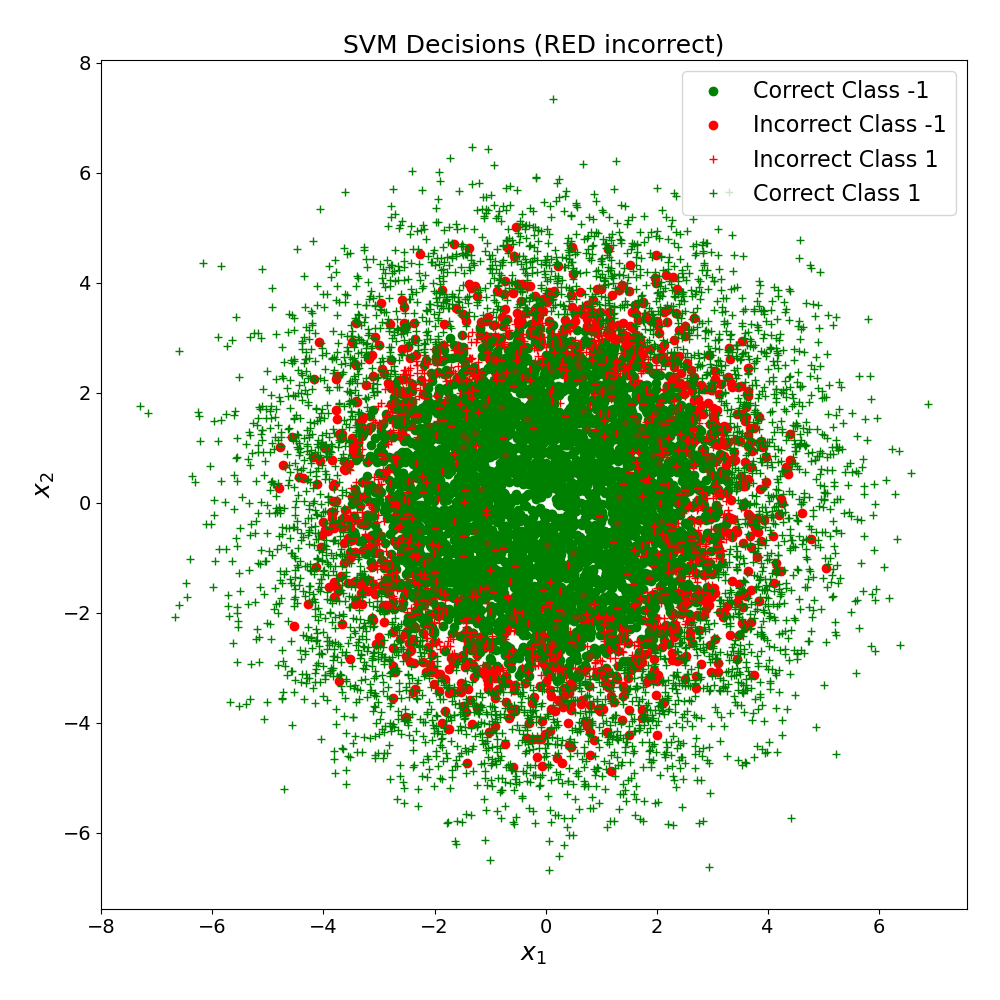

In [5]:
# Train SVM using best parameters on entire training data set
classifier = SVC(C=C_best, kernel='rbf', gamma=gamma_best)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Get indices of correct and incorrect labels
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("SVM Pr(error) on the test data set: %.4f\n" % prob_error_test)

plot_binary_classification_results(predictions, y_test, title="SVM Decisions (RED incorrect)")

### MLP

This copies over a lot of the code from [HW3](hw3.ipynb).

In [6]:
class TwoLayerMLP(nn.Module):
    # Two-layer neural network class
    
    def __init__(self, in_dim, P, out_dim):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from n -> P
        self.input_fc = nn.Linear(in_dim, P)
        # Output layer again fully connected mapping from P -> out_dim (# classes)
        self.output_fc = nn.Linear(P, out_dim)
        
    def forward(self, X):
        # X = [batch_size, input_dim]
        X = self.input_fc(X)
        # ReLU
        X = F.relu(X)
        # X = [batch_size, P]
        y = self.output_fc(X)
        return y
    
def model_train(model, data, labels, optimizer, criterion=nn.CrossEntropyLoss(), num_epochs=100):
    # Set this "flag" before training
    model.train()
    # Optimize the model, e.g. a neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model, loss

def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        decisions = np.argmax(predicted_labels, 1)

        return decisions

> With the single-hidden layer MLP class defined above, alongside other training/prediction utility functions, we can now select the optimal number of perceptrons $P^*$ using cross-validation. Please see below:

In [7]:
def k_fold_cv_perceptrons(K, P_list, data, labels):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    error_valid_mk = np.zeros((len(P_list), K)) 

    # STEP 2: Iterate over all model options based on number of perceptrons
    # Track model index
    m = 0
    for P in P_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            # Extract the training and validation sets from the K-fold split
            # Convert numpy structures to PyTorch tensors, necessary data types
            X_train_k = torch.FloatTensor(data[train_indices])
            y_train_k = torch.LongTensor(labels[train_indices])

            model = TwoLayerMLP(X_train_k.shape[1], P, out_dim=2)

            # Stochastic GD with learning rate and momentum hyperparameters
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            
            # Trained model
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)

            X_valid_k = torch.FloatTensor(data[valid_indices])
            y_valid_k = labels[valid_indices]
            
            # Evaluate the neural network on the validation fold
            predictions = model_predict(model, X_valid_k)
            # Retain the probability of error estimates
            error_valid_mk[m, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        m += 1
    
    # STEP 3: Compute the average prob. error (across K folds) for that model
    error_valid_m = np.mean(error_valid_mk, axis=1) 
    
    # Return the optimal choice of P* and prepare to train selected model on entire dataset
    optimal_P = P_list[np.argmin(error_valid_m)]
    
    print("Best # of Perceptrons: %d" % optimal_P)
    print("Pr(error): %.3f" % np.min(error_valid_m))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(P_list, error_valid_m)
    plt.title("No. Perceptrons vs Cross-Validation Pr(error)")
    plt.xlabel(r"$P$")
    plt.ylabel("MLP CV Pr(error)")
    plt.show()

    return optimal_P

> Now we report the optimal number of perceptrons $P^*$ for our training set:

Best # of Perceptrons: 48
Pr(error): 0.174


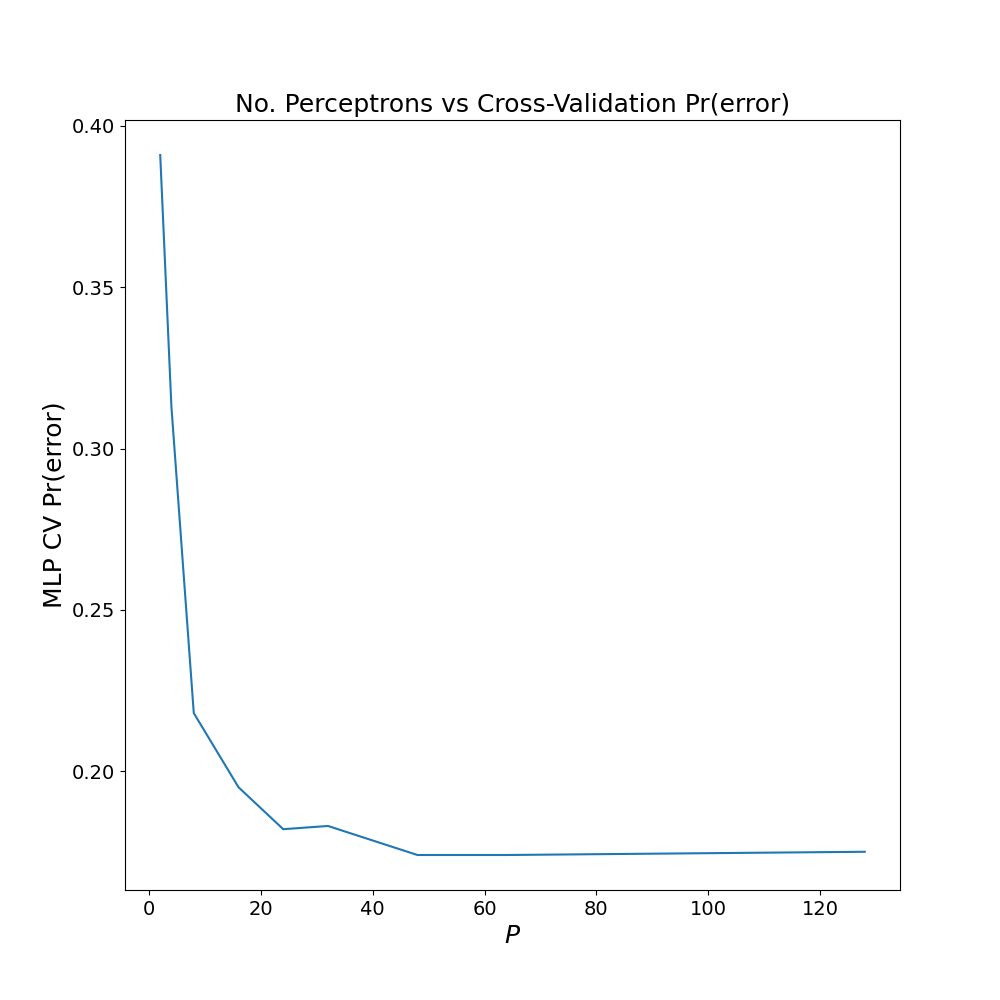

In [8]:
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128]

# Converting -1/+1 labels into a one-hot numerical format, suitable for the MLP loss function
lb = LabelBinarizer()
y_train_hot = lb.fit_transform(y_train)[:, 0]
    
P_best = k_fold_cv_perceptrons(K, P_list, X_train, y_train_hot)

> Mitigate the chances of getting stuck at a local optimum by randomly reinitializing each MLP training routine multiple times and getting the highest training-data log-likelihood solution encountered.

In [9]:
# Number of times to re-train same model with random re-initializations
num_restarts = 10

# Convert numpy structures to PyTorch tensors, necessary data types
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train_hot)
            
# List of trained MlPs for later testing
restart_mlps = []
restart_losses = []
# Remove chances of falling into suboptimal local minima
for r in range(num_restarts):
    model = TwoLayerMLP(X_train.shape[1], P_best, out_dim=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Trained model
    model, loss = model_train(model, X_train_tensor, y_train_tensor, optimizer)
    restart_mlps.append(model)
    restart_losses.append(loss.detach().item())

# Choose best model from multiple restarts to list
best_mlp = restart_mlps[np.argmin(restart_losses)]

> After training the MLP using the entire training set and the best $P^*$ option multiple times to avoid getting stuck in local minima, we now report on probability of error on the test set. We will also draw the resulting classifier's correct vs incorrect decisions, as we previously did for the SVM.

MLP Pr(error) on the test data set: 0.1737



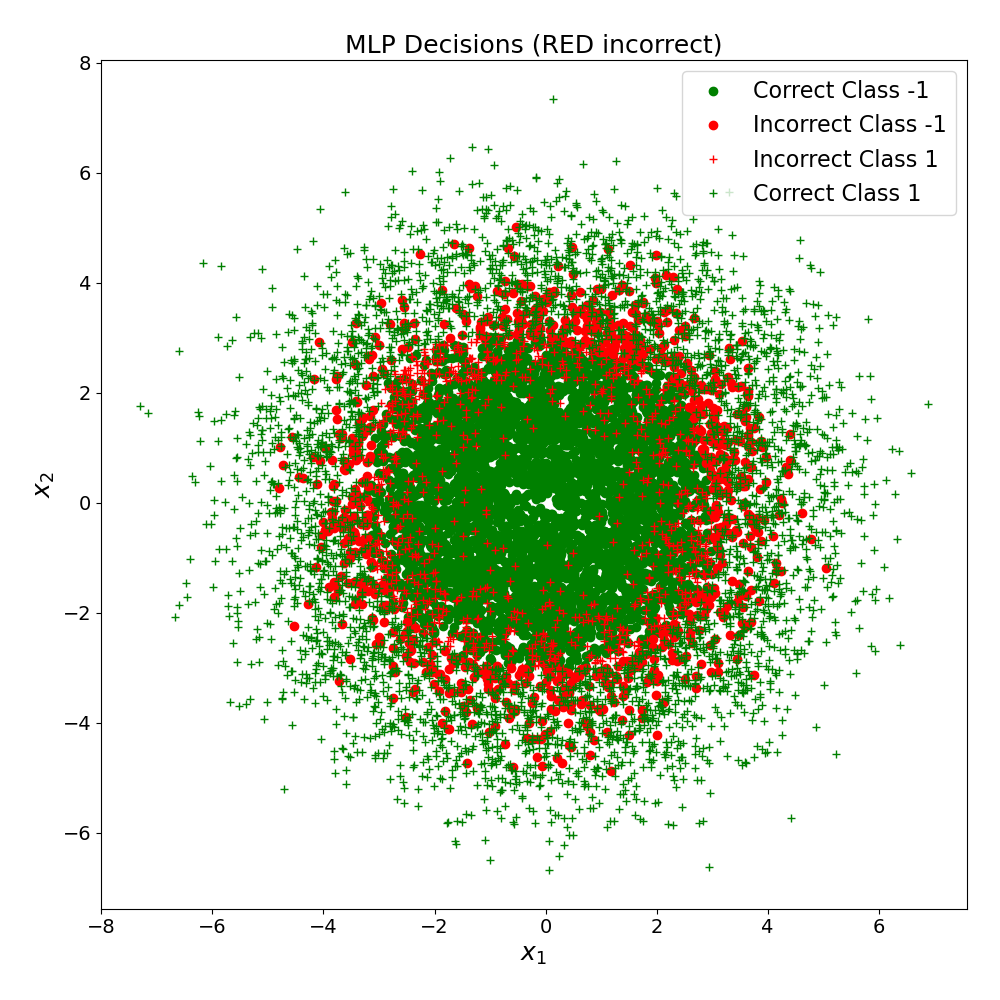

In [10]:
X_test_tensor = torch.FloatTensor(X_test)

# Evaluate the neural network on the test set
predictions_hot = model_predict(best_mlp, X_test_tensor)
# Return back to original encoding
predictions = lb.inverse_transform(predictions_hot)

# Get indices of correct and incorrect labels
incorrect_ind = np.argwhere(y_test != predictions)
prob_error_test = len(incorrect_ind) / N_test
print("MLP Pr(error) on the test data set: %.4f\n" % prob_error_test)

plot_binary_classification_results(predictions, y_test, title="MLP Decisions (RED incorrect)")

Report the following: (1) visual and numerical demonstrations of the K-fold cross-validation process indicating how the hyperparameters for SVM and MLP classifiers are set; (2) visual and numerical demonstrations of the performance of your SVM and MLP classifiers on the test data set. It is your responsibility to figure out how to present your results in a convincing fashion to indicate the quality of the training/model selection procedure and the test performance estimate.

<i>Hint: For hyperparameter selection, you may show the performance estimates for various choices and indicate where the best result is achieved. For test performance, you may show the data and classification boundary superimposed, along with an estimated probability of error from the samples. Modify and supplement these ideas as you see appropriate.</i>

> The two classifiers obtain extremely similar performance in terms of probability of error.

## Question 2

In this question, you will use GMM-based clustering to segment a color image. Pick your color image from [this dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/dataset/images.html).

Text(0.5, 1.0, 'Boat Color')

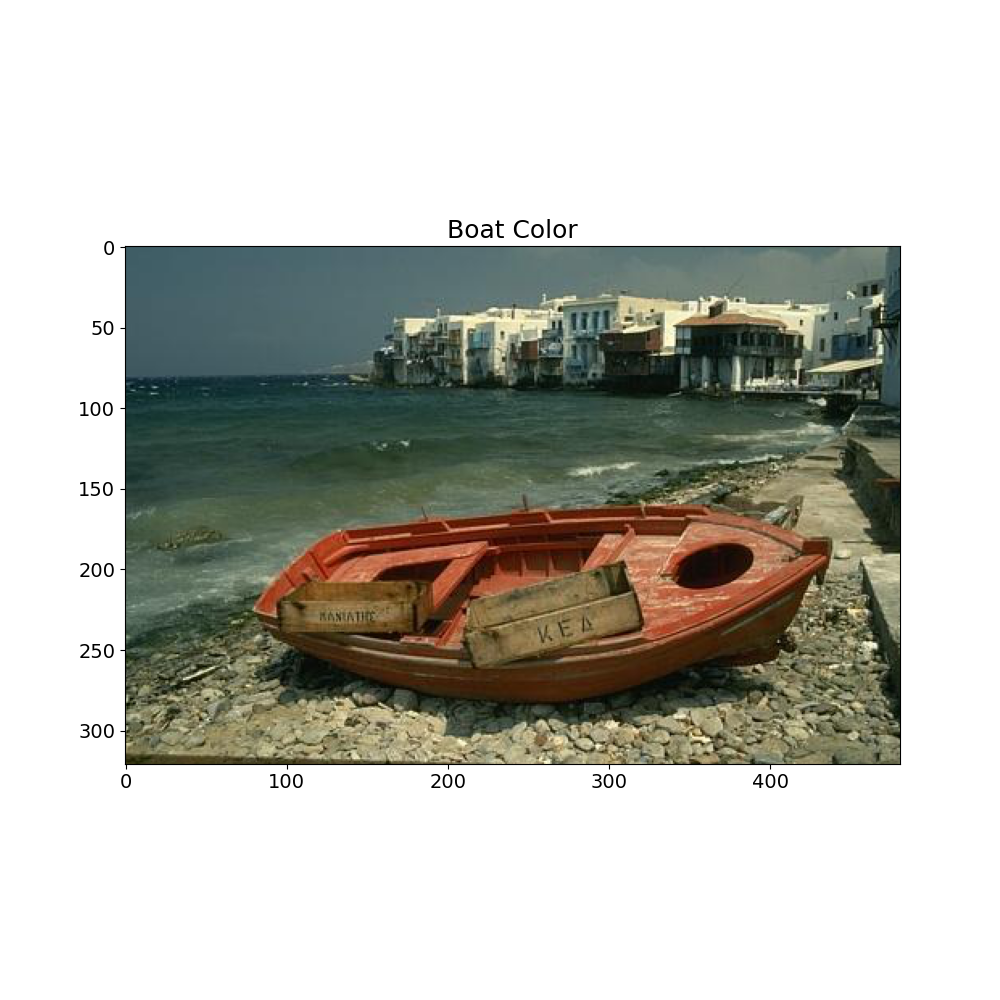

In [11]:
boat_color = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/118020.jpg')

fig = plt.figure(figsize=(10, 10))
plt.imshow(boat_color)
plt.title("Boat Color")

### Feature Generation

As preprocessing, for each pixel, generate a 5-dimensional feature vector as follows: (1) append row index, column index, red value, green value, blue value for each pixel into a raw feature vector; (2) normalize each feature entry individually to the interval $[0,1]$, so that all of the feature vectors representing every pixel in an image fit into the 5-dimensional unit-hypercube.

In [12]:
def generate_feature_vector(image):
    # Load image, get its dimensions
    image_np = np.array(image)
    # Return an array of the row and column indices of the image (height and width)
    img_indices = np.indices((image_np.shape[0], image_np.shape[1]))
        
    # Set up data array to store features: row ind, col ind, [num_channels]
    # num_channels = 1 for grayscale and 3 for RGB
    if image_np.ndim == 2:  # Grayscale image
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), image_np.flatten()])
        # Find ranges of features as max - min
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min) 
        # New axis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    elif image_np.ndim == 3: # Color image with RGB values
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), 
                             image_np[..., 0].flatten(), image_np[..., 1].flatten(), image_np[..., 2].flatten()])
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min) 
        # New axis np.newaxis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    else:
        print("Incorrect image dimensions for feature vector")
        
    # Returns feature vector of normalized pixels as shape (height*width, 3 or 5)
    return image_np, normalized_data.T

### GMM Clustering & Selecting $K$

Fit a Gaussian Mixture Model (GMM) to these normalized feature vectors representing the pixels of the image. To fit the GMM, use maximum likelihood parameter estimation (e.g., via Expectation Maximisation as in the "fit" function of the [GaussianMixture class](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)) and 10-fold cross-validation with maximum average validation-log-likelihood as the objective for model order selection.
Once you have identified the <i>best</i> GMM for your feature vectors, assign the most likely component label (MAP) to each pixel by evaluating component label posterior probabilities for each feature vector. Present the original image and your GMM-based segmentation labels assigned to each pixel side-by-side for easy visual assessment of your segmentation outcome. If using grayscale values as segment/component labels, please uniformly distribute them between min/max grayscale values to have good contrast in the label image.

<i>Hint: If the image has too many pixels for your available computational power, you may downsample the image to reduce overall computational needs</i>

> Let's quickly see what the segmentation result looks like for $K=4$ components:

Text(0.5, 1.0, 'GMM Image Segmentation Result with $K = 4$')

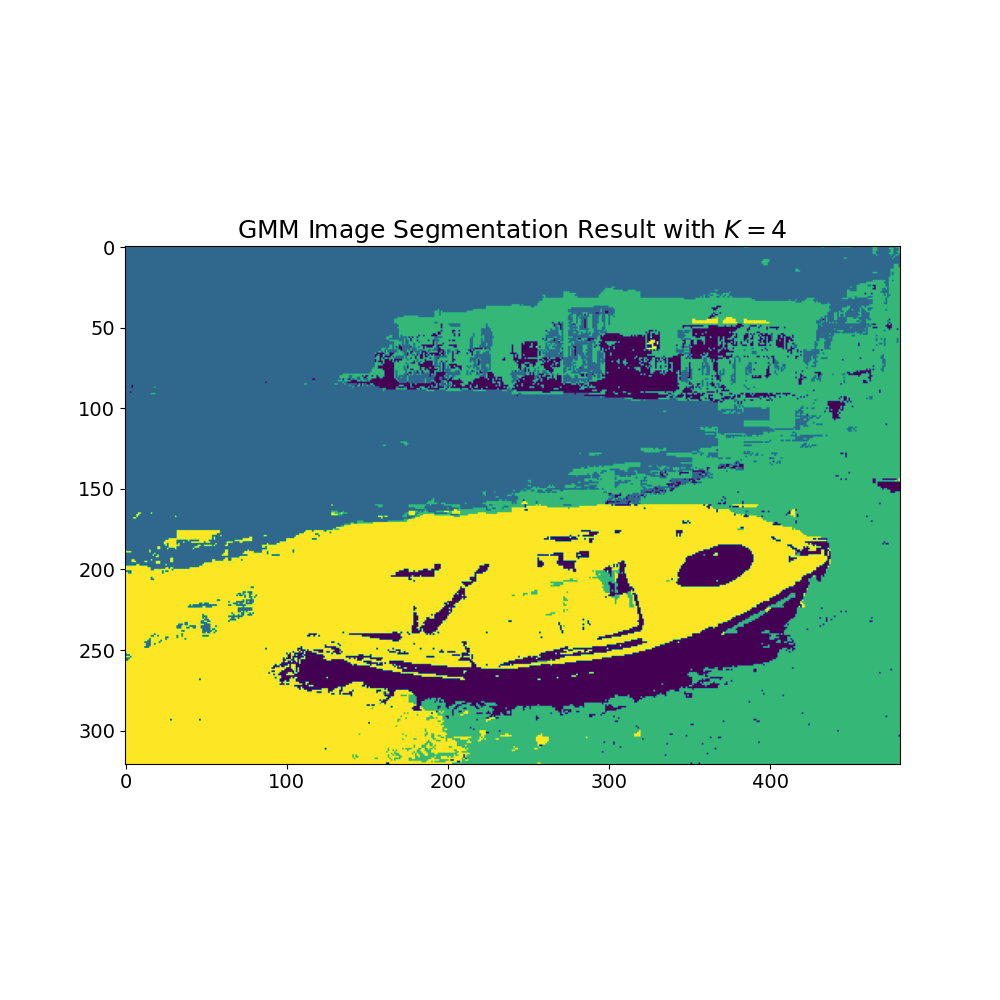

In [13]:
## Generate feature vector on the image
img_np, feature_vector = generate_feature_vector(boat_color)   
    
# Perform EM to estimate the parameters of the GMM using fit() and default parameters
gmm = GaussianMixture(n_components=4)

# Hard clustering using argmax to compute most probable component labels
gmm_predictions = gmm.fit_predict(feature_vector) 

# Assigned segment labels reshaped into an image to color-code pixels
labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])
fig = plt.figure(figsize=(10, 10))
plt.imshow(labels_img)
plt.title(r"GMM Image Segmentation Result with $K = 4$")

In [14]:
def k_fold_gmm_components(K, n_components_list, data):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    log_lld_valid_mk = np.zeros((len(n_components_list), K)) 

    # STEP 2: Iterate over all model options based on number of components
    # Track model index
    m = 0
    for comp in n_components_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            gmm = GaussianMixture(n_components=comp).fit(feature_vector)
            
            # Per-sample average log-likelihood
            log_lld_valid_mk[m, k] = gmm.score(feature_vector) 
            k += 1
        m += 1
    
    # STEP 3: Compute the average validation set log-likelihood (across K folds)
    log_lld_valid_m = np.mean(log_lld_valid_mk, axis=1) 
    
    # Extracting top 3 K-components with largest log-likelihood values, to later illustrate
    best_three_ind = np.argpartition(log_lld_valid_m, -3)[-3:]
    # Need to sort them
    best_three = best_three_ind[np.argsort((-log_lld_valid_m)[best_three_ind])]
    # Optimal K* component is the one that maximizes average validation-log-likelihood
    print("Best No. Cluster Components: %d" % n_components_list[best_three[0]])
    print("Log-likelihood Score: %.3f" % np.max(log_lld_valid_m))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(n_components_list, log_lld_valid_m);
    plt.title("No. Components vs Cross-Validation Log-Likelihood")
    plt.xlabel(r"$K$")
    plt.ylabel("Log-likelihood")
    ax = fig.gca();
    ax.xaxis.set_major_locator(MaxNLocator(integer=True));
    plt.show()

    # Return the best three number of components for clustering   
    return [n_components_list[i] for i in best_three]

Best No. Cluster Components: 20
Log-likelihood Score: 6.329


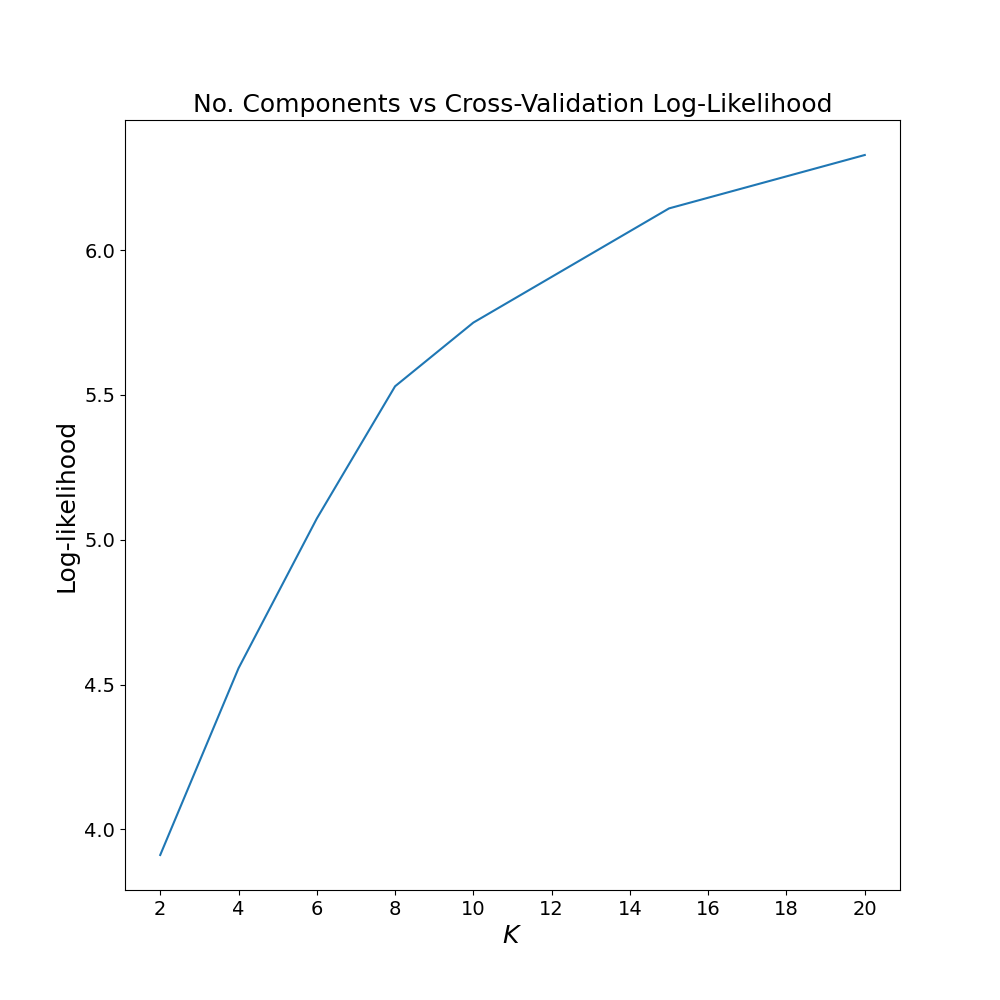

In [15]:
K_folds = 10
n_components_list = [2, 4, 6, 8, 10, 15, 20]

best_three_components = k_fold_gmm_components(K_folds, n_components_list, feature_vector)

> Finally, let's see what the top three $K$ clustering selections generate as a segmentation result:

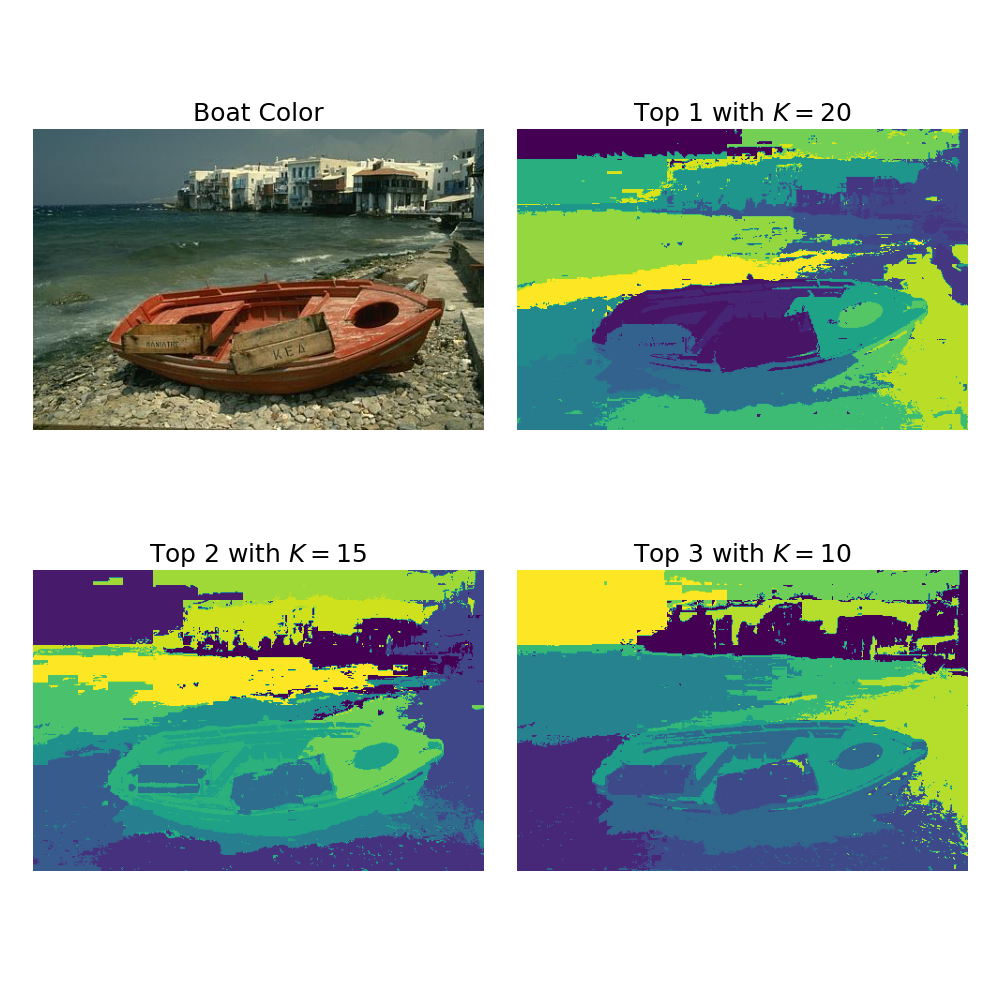

In [16]:
# Create figure to plot all GMM segmentation results for the example image
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(boat_color)
ax[0,0].set_title("Boat Color")
ax[0,0].set_axis_off()

# Plot axis index for each clustered image 
j = 1
for comp in best_three_components:
    gmm_predictions = GaussianMixture(n_components=comp).fit_predict(feature_vector)
    labels_img = gmm_predictions.reshape(img_np.shape[0], img_np.shape[1])
    
    ax[floor(j/2),j%2].imshow(labels_img)
    ax[floor(j/2),j%2].set_title(fr"Top {j} with $K = {comp}$")
    ax[floor(j/2),j%2].set_axis_off()
    j += 1
    
plt.tight_layout()
plt.show()

> There is a clear trend for the number of components $K$ to improve the log-likelihood objective of the CV procedure for GMM clustering. This partly resonates with the footnote in the Questions sheet on the issue of using CV with certain metrics to guide the hyperparameter selection. It seems perceptually from the $K=4$ image segmentation result that even this lower value might have been more appropriate for the task-at-hand. This motivates the well-known challenge in unsupervised learning settings of choosing the right metrics for evaluation.

> However, for this task I would also refer you to other means of performing model selection, namely using information criteria. Examples include [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion#:~:text=The%20Akaike%20information%20criterion%20(AIC,a%20means%20for%20model%20selection.), both of which could be better candidates for selecting the best number of components $K$ in this problem! Also please refer to the relevant chapter from Murphy's book Bayesian model selection (21.4.1.3).